In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  # natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History
from tensorflow.keras import losses

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K

import tensorflow as tf

from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
!pip install pydotplus
!pip install graphviz

In [6]:
!pip install -q kaggle

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d kaushiksuresh147/bitcoin-tweets

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/kaushiksuresh147/bitcoin-tweets
License(s): CC0-1.0
 98% 684M/695M [00:07<00:00, 109MB/s]
100% 695M/695M [00:07<00:00, 96.3MB/s]


In [15]:
!unzip "/content/bitcoin-tweets.zip"

Archive:  /content/bitcoin-tweets.zip
  inflating: Bitcoin_tweets.csv      
  inflating: Bitcoin_tweets_dataset_2.csv  


In [16]:
!ls /content/


Bitcoin_tweets.csv  Bitcoin_tweets_dataset_2.csv  bitcoin-tweets.zip  kaggle.json  sample_data


In [17]:
df = pd.read_csv('Bitcoin_tweets.csv',chunksize=100000,lineterminator='\n')
df = pd.concat(df)

<ipython-input-17-fcde9b7271df>:2: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df)
<ipython-input-17-fcde9b7271df>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df)
<ipython-input-17-fcde9b7271df>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df)
<ipython-input-17-fcde9b7271df>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df)
<ipython-input-17-fcde9b7271df>:2: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df)
<ipython-input-17-fcde9b7271df>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.concat(df)
<ipython-input-17-fcde9b7271df>:2: DtypeWarning: 

In [18]:
df=df[['text']][0:20000]
df

,text
0,Blue Ridge Bank shares halted by NYSE after #b...
1,"😎 Today, that's this #Thursday, we will do a ""..."
2,"Guys evening, I have read this article about B..."
3,$BTC A big chance in a billion! Price: \487264...
4,This network is secured by 9 508 nodes as of t...
...,...
19995,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...
19996,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...
19997,LINK IN MY BIO!!! \nFlex is dropping officiall...
19998,#Bitcoin #Btc\n\nWait and see.... https://t.co...


In [19]:
def tweet2words(tweet):
    '''
    Convert tweet text into a sequence of words
    :tweet -> text data
    '''

    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

In [20]:
cleantext=[]
for item in tqdm(df['text']):
    words=tweet2words(item)
    cleantext+=[words]
df['cleantext']=cleantext
df

100%|██████████| 20000/20000 [01:19<00:00, 251.94it/s]


,text,cleantext
0,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,..."
1,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl..."
2,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh..."
3,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ..."
4,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi..."
...,...,...
19995,⬇️⬇️ $BTC SELLING PRESSURE ALERT 📉 Price tradi...,"[btc, sell, pressur, alert, price, trade, arou..."
19996,@HusseinChindo @kayodebakre8 Wrong! #Bitcoin i...,"[husseinchindo, kayodebakre8, wrong, bitcoin, ..."
19997,LINK IN MY BIO!!! \nFlex is dropping officiall...,"[link, bio, flex, drop, offici, tomorrow, feb,..."
19998,#Bitcoin #Btc\n\nWait and see.... https://t.co...,"[bitcoin, btc, wait, see, http, co, vdaseguhlp]"


In [21]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

In [22]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

In [29]:
df1 = compute_vader_scores(df,'cleantext')
df1.head()


,text,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,Blue Ridge Bank shares halted by NYSE after #b...,"[blue, ridg, bank, share, halt, nyse, bitcoin,...",0.0,0.872,0.128,0.2960,blue ridg bank share halt nyse bitcoin atm ann...
1,"😎 Today, that's this #Thursday, we will do a ""...","[today, thursday, take, 2, friend, leowandersl...",0.0,0.775,0.225,0.4939,today thursday take 2 friend leowandersleb btc...
2,"Guys evening, I have read this article about B...","[guy, even, read, articl, btc, would, like, sh...",0.0,0.719,0.281,0.5719,guy even read articl btc would like share http...
3,$BTC A big chance in a billion! Price: \487264...,"[btc, big, chanc, billion, price, 4872644, 0, ...",0.0,1.000,0.000,0.0000,btc big chanc billion price 4872644 0 2021 02 ...
4,This network is secured by 9 508 nodes as of t...,"[network, secur, 9, 508, node, today, soon, bi...",0.2,0.800,0.000,-0.5423,network secur 9 508 node today soon biggest be...


In [26]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

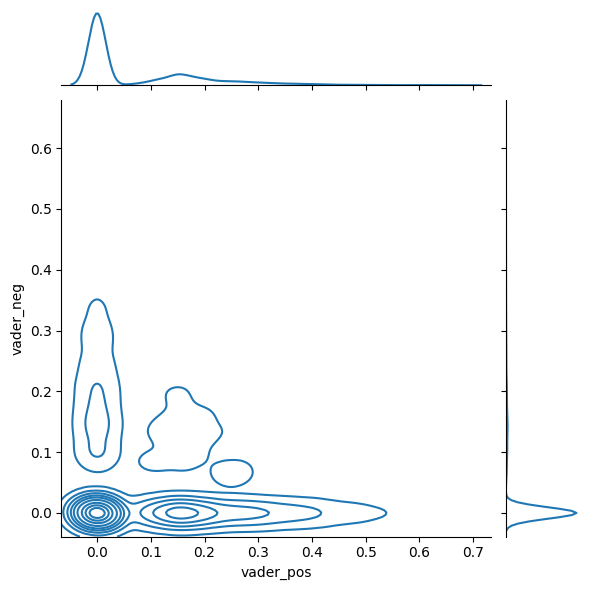

In [30]:
sns.jointplot(data=df, x='vader_pos', y='vader_neg', kind="kde")

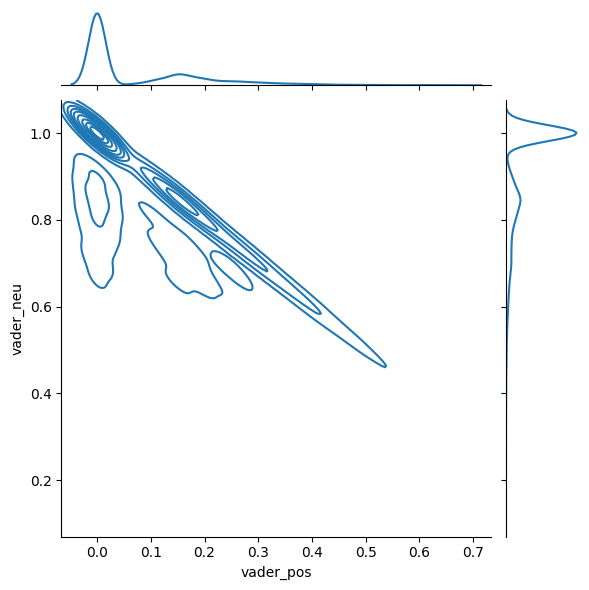

In [31]:
sns.jointplot(data=df1, x='vader_pos', y='vader_neu', kind="kde")

In [34]:
class0=[]
for i in range(len(df1)):
    if df1.loc[i,'vader_neg']>0:
        class0+=[0]
    elif df1.loc[i,'vader_pos']>0:
        class0+=[2]
    else:
        class0+=[1]

In [35]:
df['class']=class0
df['class'].value_counts()

class
1    11246
2     6079
0     2675
Name: count, dtype: int64

In [36]:
max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('After Tokenization & Padding \n', X[0])


Before Tokenization & Padding 
 blue ridg bank share halt nyse bitcoin atm announc http co xaazmajkiv myblueridgebank http co sgbxmkp1si 
After Tokenization & Padding 
 [1399 1804  254  406 3652 2760    3 1149  259    2    1    2    1    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [37]:
y = pd.get_dummies(df['class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set: ', X_train.shape, y_train.shape)
print('Validation Set: ', X_val.shape, y_val.shape)
print('Test Set: ', X_test.shape, y_test.shape)

Train Set:  (12000, 50) (12000, 3)
Validation Set:  (4000, 50) (4000, 3)
Test Set:  (4000, 50) (4000, 3)


In [38]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [39]:
vocab_size = 5000
embedding_size = 32
epochs = 10
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

In [40]:
import tensorflow as tf
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [42]:
from tensorflow.keras.optimizers import SGD


# Remove the decay parameter from the SGD optimizer
sgd = SGD(learning_rate=0.1, momentum=momentum, nesterov=False)

# Build model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))


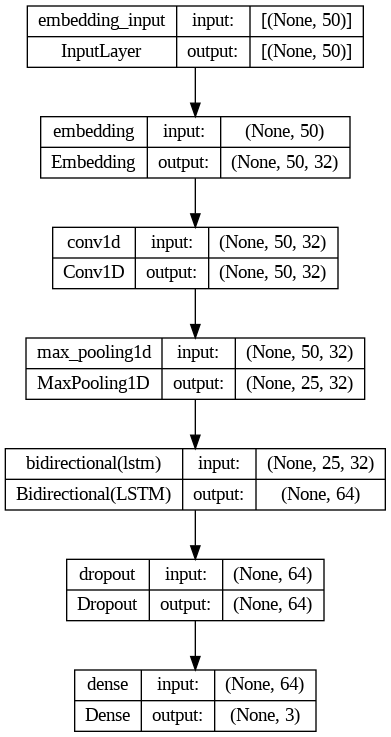

In [43]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [44]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy', Precision(), Recall()])

In [45]:
history = model.fit(X_train,y_train,validation_data=(X_val, y_val),batch_size=64,epochs=epochs,verbose=1)

Epoch 1/10
188/188 [==============================] - 13s 33ms/step - loss: 0.9576 - accuracy: 0.5633 - precision: 0.5665 - recall: 0.5165 - val_loss: 0.9479 - val_accuracy: 0.5663 - val_precision: 0.5663 - val_recall: 0.5663
Epoch 2/10
188/188 [==============================] - 12s 66ms/step - loss: 0.8810 - accuracy: 0.5948 - precision: 0.6450 - recall: 0.4852 - val_loss: 0.7965 - val_accuracy: 0.6525 - val_precision: 0.7442 - val_recall: 0.5173
Epoch 3/10
188/188 [==============================] - 14s 73ms/step - loss: 0.5472 - accuracy: 0.7914 - precision: 0.8312 - recall: 0.7455 - val_loss: 0.4297 - val_accuracy: 0.8420 - val_precision: 0.8668 - val_recall: 0.8378
Epoch 4/10
188/188 [==============================] - 5s 27ms/step - loss: 0.3361 - accuracy: 0.8676 - precision: 0.8816 - recall: 0.8547 - val_loss: 0.3286 - val_accuracy: 0.8953 - val_precision: 0.8995 - val_recall: 0.8857
Epoch 5/10
188/188 [==============================] - 6s 33ms/step - loss: 0.2583 - accuracy: 0.9

In [46]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9663
Precision : 0.9667
Recall    : 0.9663
F1 Score  : 0.9665


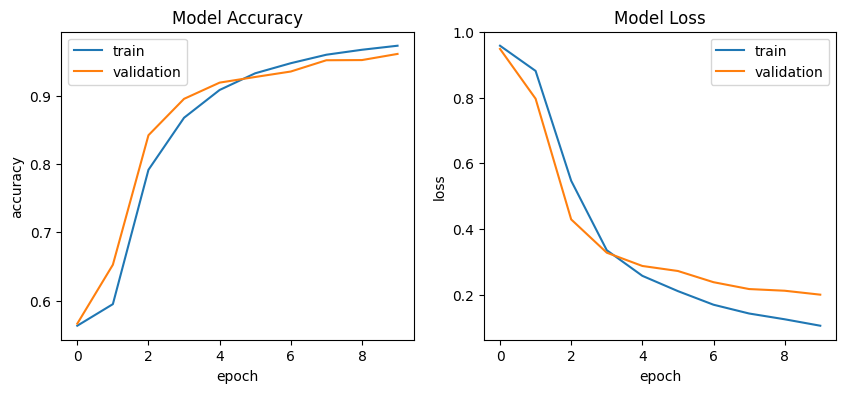

In [48]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')

    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

125/125 [==============================] - 6s 15ms/step
1    2203
2    1251
0     546
Name: count, dtype: int64
1    2255
2    1247
0     498
Name: count, dtype: int64


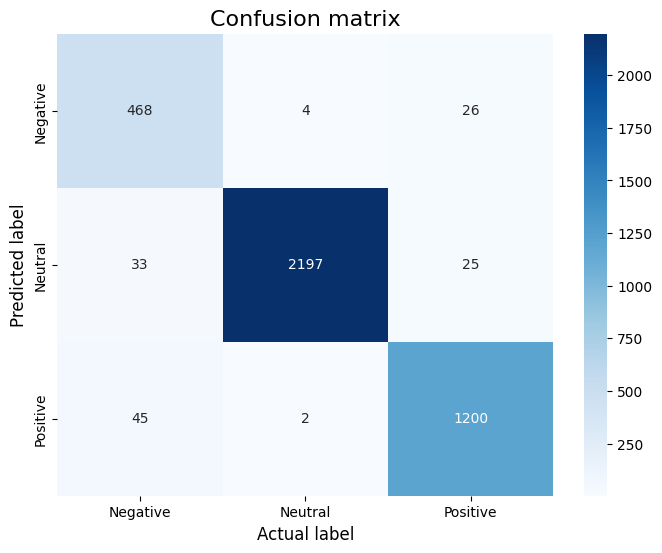

In [49]:
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative','Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

    print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
    print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())

    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

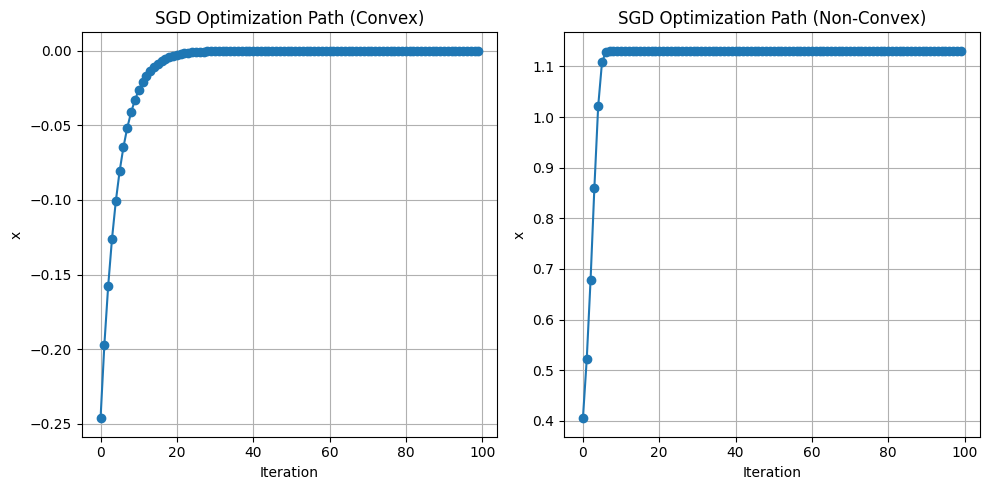

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Objective functions
def convex_function(x):
    return x**2

def non_convex_function(x):
    return x**4 - 3*x**2 + x

# Gradient descent function
def sgd_optimization(func, lr=0.1, num_steps=100):
    history = []
    x = np.random.uniform(-2, 2)  # Random initial point
    for _ in range(num_steps):
        gradient = 2 * x if func == convex_function else 4 * x**3 - 6 * x + 1
        x -= lr * gradient
        history.append(x)
    return history

# Optimization paths
convex_path = sgd_optimization(convex_function)
non_convex_path = sgd_optimization(non_convex_function)

# Plot optimization paths
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(convex_path)), convex_path, marker='o', linestyle='-')
plt.title('SGD Optimization Path (Convex)')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(np.arange(len(non_convex_path)), non_convex_path, marker='o', linestyle='-')
plt.title('SGD Optimization Path (Non-Convex)')
plt.xlabel('Iteration')
plt.ylabel('x')
plt.grid(True)

plt.tight_layout()
plt.show()


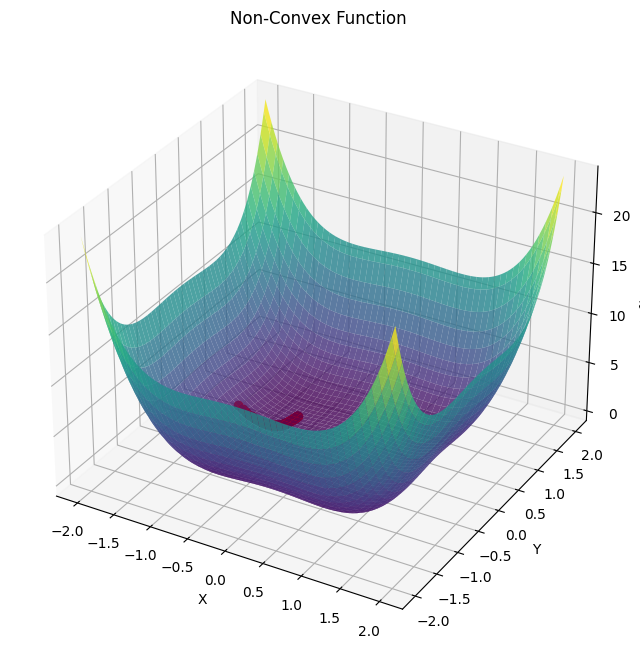

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Objective function
def non_convex_function(x, y):
    return x**4 + y**4 - x**2 - y**2

# Gradient descent function
def sgd_optimization_3d(func, lr=0.01, num_steps=100):
    history = []
    x = np.random.uniform(-2, 2)  # Random initial point
    y = np.random.uniform(-2, 2)  # Random initial point
    for _ in range(num_steps):
        gradient_x = 4 * x**3 - 2 * x
        gradient_y = 4 * y**3 - 2 * y
        x -= lr * gradient_x
        y -= lr * gradient_y
        history.append((x, y, func(x, y)))
    return history

# Generate optimization path
history = sgd_optimization_3d(non_convex_function)

# Plot 3D surface
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = non_convex_function(X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
ax.set_title('Non-Convex Function')

# Plot optimization path
x_opt, y_opt, z_opt = zip(*history)
ax.plot(x_opt, y_opt, z_opt, marker='o', color='red', linestyle='-')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(x, y)')

plt.show()


In [53]:
from tensorflow.keras.optimizers import Adam

# Define the parameters for Adam optimizer
learning_rate = 0.001  # Adjust as needed
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-07  # Small constant to prevent division by zero

# Create Adam optimizer instance
adam = Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

# Build model
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model2.add(Conv1D(filters=32, kernel_size=1, padding='same', activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Bidirectional(LSTM(32)))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation='softmax'))

In [54]:
# Compile the model with Adam optimizer
adam = Adam(learning_rate=0.001)  # Adjust learning rate as needed
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))



Epoch 1/10
375/375 [==============================] - 22s 30ms/step - loss: 0.6511 - accuracy: 0.7272 - val_loss: 0.3894 - val_accuracy: 0.8533
Epoch 2/10
375/375 [==============================] - 12s 33ms/step - loss: 0.2414 - accuracy: 0.9222 - val_loss: 0.1995 - val_accuracy: 0.9442
Epoch 3/10
375/375 [==============================] - 18s 48ms/step - loss: 0.0889 - accuracy: 0.9771 - val_loss: 0.1492 - val_accuracy: 0.9600
Epoch 4/10
375/375 [==============================] - 19s 51ms/step - loss: 0.0505 - accuracy: 0.9882 - val_loss: 0.1517 - val_accuracy: 0.9628
Epoch 5/10
375/375 [==============================] - 15s 41ms/step - loss: 0.0334 - accuracy: 0.9924 - val_loss: 0.1781 - val_accuracy: 0.9567
Epoch 6/10
375/375 [==============================] - 8s 22ms/step - loss: 0.0252 - accuracy: 0.9942 - val_loss: 0.1962 - val_accuracy: 0.9557
Epoch 7/10
375/375 [==============================] - 15s 40ms/step - loss: 0.0191 - accuracy: 0.9959 - val_loss: 0.1962 - val_accuracy: 

ValueError: too many values to unpack (expected 2)

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate the model and get loss and accuracy
loss, accuracy = model2.evaluate(X_test, y_test, verbose=0)

# Get the model predictions on the test data
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert one-hot encoded labels to class labels
y_true_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_labels, y_pred_labels, average='macro')
recall = recall_score(y_true_labels, y_pred_labels, average='macro')
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1))

125/125 [==============================] - 1s 6ms/step
Accuracy  : 0.9617
Precision : 0.9588
Recall    : 0.9379
F1 Score  : 0.9477


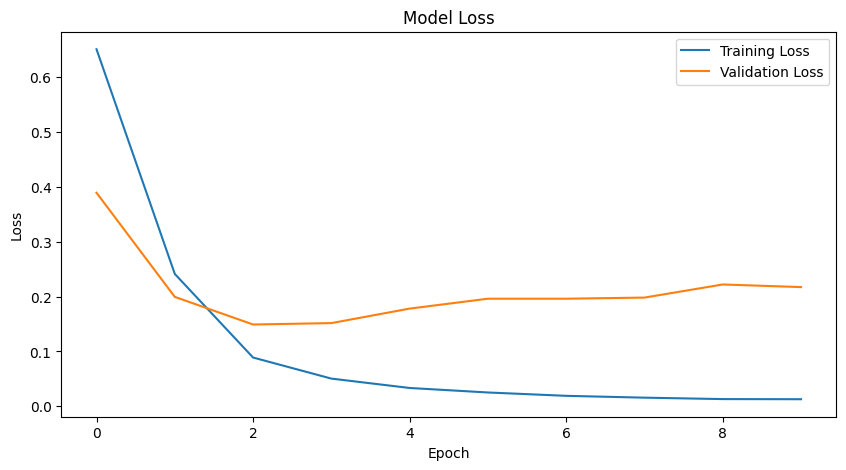

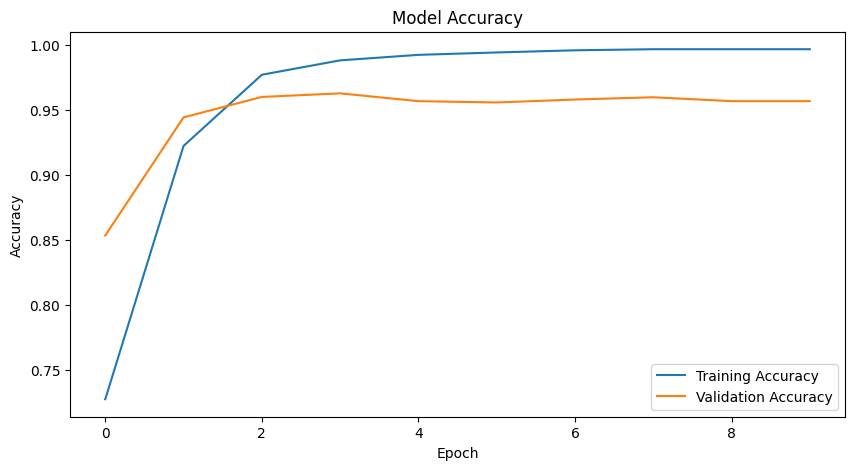

In [61]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [62]:
# Save the SGD model
model.save('sgd_model.h5')

# Save the Adam model
model2.save('adam_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
